#Hyperspectral Target Detection Tutorial Overview

This tutorial introduces key concepts and practical steps for classical statistical hyperspectral target detection.


By the end of this tutorial, you will learn how to:

1. Read and analyze hyperspectral data files (**ENVI** format) using Python libraries.

2. Implement **classical statistical target detection algorithms** including:

    * Spectral Angle Mapper (**SAM**)

    * Matched Filter (**MF**)

    * Adaptive Cosine Estimator (**ACE**)

    * Constrained Energy Minimization (**CEM**)

3. Apply and experiment with detection thresholds to identify targets.

4. Evaluate detection performance using **ROC** curves.

5. Perform **PCA** for dimensionality reduction, project the data into the principal component domain, and apply the detection algorithms in the reduced space.    


#Dataset Description:

Three files are provided along with this code:

1. An example hyperspectral image in ENVI format

    '001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84',
    
    '001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84.hdr'

2. A target signature file
    
    'Red Felt Refl ASD Reseamp 360 ASCII.txt'

3. Ground truth (class map) for red targets in the scene

    'class_map_envi',

    'class_map_envi.hdr'

Goal:  **Detect the red targets** in the hyperspectral image.


#Organization of the Tutorial:
This tutorial is organized in three steps.
- Step 1: Preprocessing the dataset before applying target detection algorithms.

- Step 2: Coding the hyperspectral target detection algorithms (SAM, MF, ACE and CEM), analyzing their results, and compairing their performances using Receiver Operating Characteristics (ROC) curve.

- Step 3: Now, let's reduce the hsi data into reduced space using PCA and apply target detection algorithms in reduced space. Also check if reconstructed data using all PC bands yields similar results as original hsi data.


###**Prepared By: Sagar Lekhak**
             
             PhD Student, Chester F. Carlson Center for Imaging Science
             Rochester Insitute of Technology, NY, USA
             sl3088@rit.edu

###**Research Advisor: Prof. Dr. Emmett J. Ientilucci**
             Gerald W. Harris Professor
             Chester F. Carlson Center for Imaging Science
             Rochester Insitute of Technology, NY, USA
             ejipci@rit.edu

#Step 1 : Preprocessing the dataset before applying target detection algorithms.

In [4]:
!pip install spectral

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spectral
import spectral.io.envi as envi

from sklearn.metrics import roc_curve, auc


In [7]:
# Read the envi files
# Replace the file path with the address in your drive.
hsi_data = envi.open('/content/drive/MyDrive/InGARSS 2025 HSI Tutorial    /001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84.hdr','/content/drive/MyDrive/InGARSS 2025 HSI Tutorial    /001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84.img')


In [8]:
# Check the data info (shape, data format, etc.).
hsi_data

	Data Source:   '/content/drive/MyDrive/InGARSS 2025 HSI Tutorial    /001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84.img'
	# Rows:             84
	# Samples:         146
	# Bands:           360
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32

In [9]:
hsi_data.shape

(84, 146, 360)

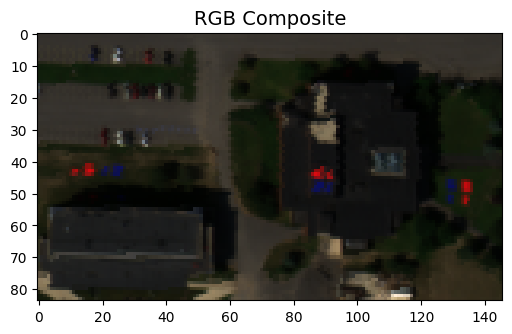

In [10]:
# Visualizing Hyperspectral Image extracting 3 RGB channels

# Select bands for RGB
red_band = 57
green_band = 36
blue_band = 13

rgb_image = np.dstack((
    hsi_data[:, :, red_band],
    hsi_data[:, :, green_band],
    hsi_data[:, :, blue_band]
))

# Normalize for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title('RGB Composite', fontsize=14)
plt.show()

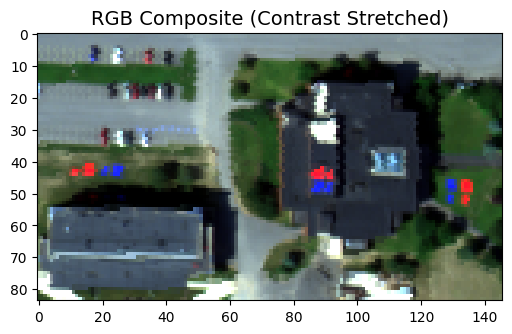

In [11]:
# For better visualization, use Contrast Stretching (2–98% Percentile)
def contrast_stretch(img, low=2, high=98):
    p_low, p_high = np.percentile(img, (low, high))
    stretched = (img - p_low) / (p_high - p_low)
    stretched = np.clip(stretched, 0, 1)
    return stretched

# Apply per band
rgb_stretched = np.zeros_like(rgb_image, dtype=float)
for i in range(3):
    rgb_stretched[:, :, i] = contrast_stretch(rgb_image[:, :, i])

# Display
plt.figure(figsize=(6, 6))
plt.imshow(rgb_stretched)
plt.title("RGB Composite (Contrast Stretched)", fontsize=14)
plt.show()

In [12]:
# Convert the data into numpy format for easier processing.
hsi_data_numpy = hsi_data.load().copy() # using .load() function to read it and .copy() to make it writable.


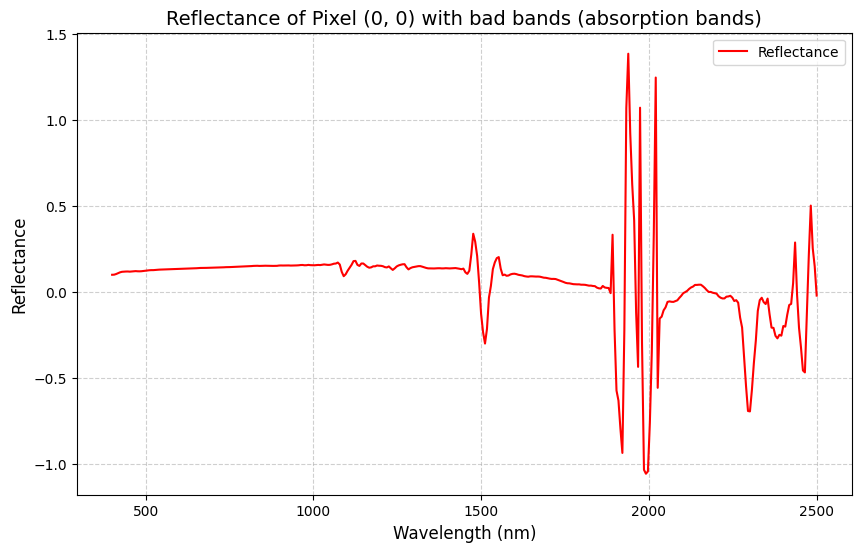

In [13]:
# Visualize a spectrum of a random pixel in the data cube.

pixel_spectrum = hsi_data[0, 0, :].flatten() # I chose the first pixel

# Create a wavelength array corresponding to the spectral bands
wavelengths = np.linspace(400, 2500, 360)  # Adjust according to your data's spectral range

# Plot the pixel spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, pixel_spectrum, color='red', label='Reflectance')

plt.title('Reflectance of Pixel (0, 0) with bad bands (absorption bands)', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [14]:
# Clean the data by removing bad bands.
# Select the bad bands and replace them by NaN value

# Bands to replace with NaN
bands_to_remove = np.concatenate([
    np.arange(113, 123),
    np.arange(142, 153),
    np.arange(181, 197),
    np.arange(252, 280),
    np.arange(319, 360)
])

# Replace the specified bands with NaN
hsi_data_numpy[:, :, bands_to_remove] = np.nan

# Check for NaN values in each band across all pixels
nan_bands = np.isnan(hsi_data_numpy).all(axis=(0, 1))  # Check for NaN values along rows and columns

# Remove bands that have NaN values
hsi_data_cleaned = hsi_data_numpy[:, :, ~nan_bands]

# Check the shape of the data after removing bad bands.
hsi_data_cleaned.shape

(84, 146, 254)

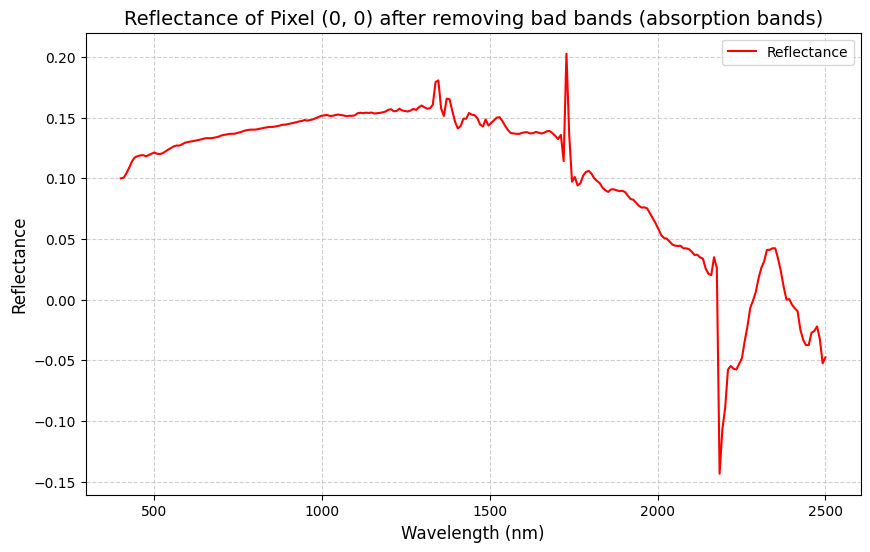

In [15]:
# Visualize the same earlier spectrum after removing the bad bands.

# Visualize the spectrum of the same random pixel chosen before in the data cube.
pixel_spectrum = hsi_data_cleaned[0, 0, :].flatten()

# Create a wavelength array corresponding to the spectral bands
wavelengths = np.linspace(400, 2500, 254)  # Adjust according to your data's spectral range

# Plot the pixel spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, pixel_spectrum, color='red', label='Reflectance')

plt.title('Reflectance of Pixel (0, 0) after removing bad bands (absorption bands)', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [16]:
# Now similarly, read the target spectrum
# Replace the filpath from your drive

# Read the CSV file, skip the first 3 rows, and assign column names
red_target_spectrum = pd.read_csv(
    '/content/drive/MyDrive/InGARSS 2025 HSI Tutorial    /Red Felt Refl ASD Reseamp 360 ASCII.txt',  # Only replace this line
    sep=r'\s+',  # Use r'\s+' to handle any whitespace separator
    header=None,  # Header removed in the file, so we can define it ourselves
    names=['Wavelength', 'Reflectance'],  # Assign column names
    skiprows=3,  # Skip the first 3 rows
    engine='python'  # Specify the Python engine for regex-based separator
)

# Display the first few rows to confirm
print(red_target_spectrum.head())

   Wavelength  Reflectance
0     0.39527     0.047856
1     0.39972     0.043325
2     0.40389     0.040157
3     0.40826     0.037591
4     0.41248     0.035439


In [17]:
# Check the shape of the spectrum
red_target_spectrum.shape

(360, 2)

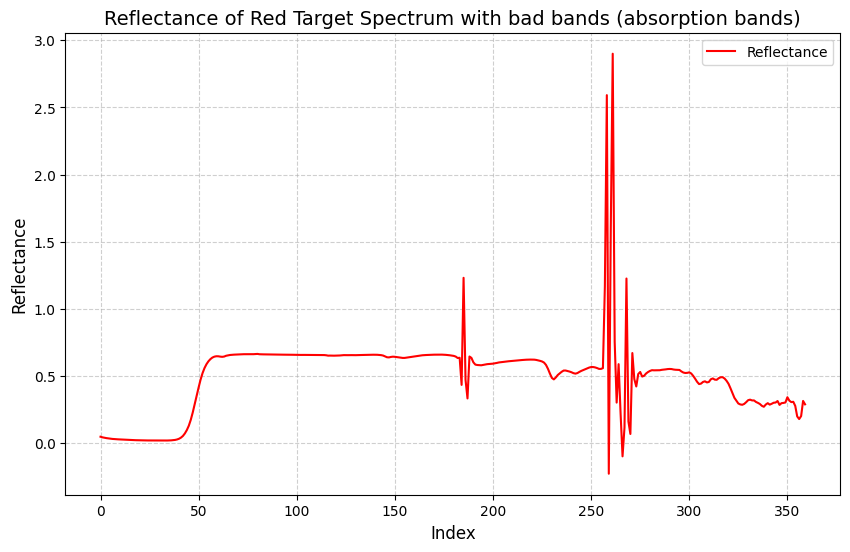

In [18]:
# Visualize the target spectrum

plt.figure(figsize=(10, 6))
plt.plot(red_target_spectrum.index, red_target_spectrum['Reflectance'], color = 'red', label='Reflectance')
plt.title('Reflectance of Red Target Spectrum with bad bands (absorption bands)', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

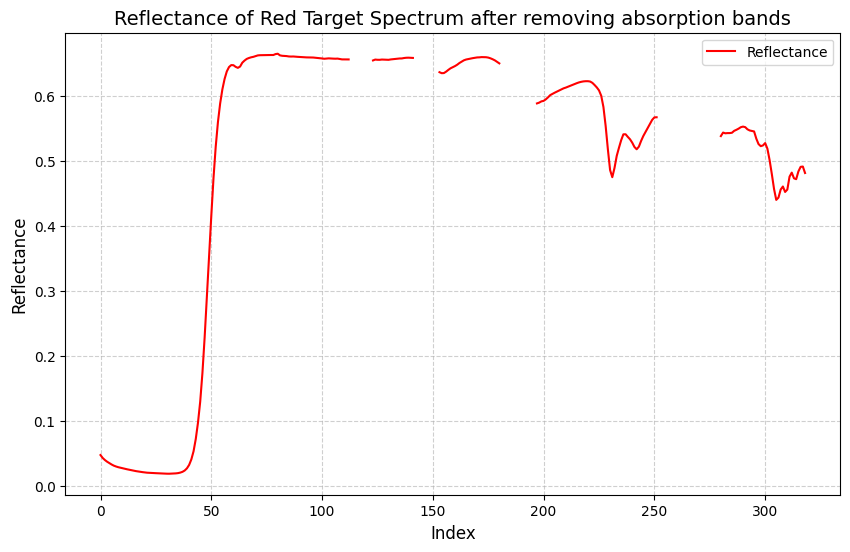

In [19]:
# Similar to the hsi_data, remove the bad bands from the spectrum

#Remove absorption bands putting 0/Nan values in those positions
red_target_spectrum.loc[np.concatenate([np.arange(113, 123),
                                 np.arange(142, 153),
                                 np.arange(181, 197),
                                 np.arange(252, 280),
                                 np.arange(319, 360)]), 'Reflectance'] = np.nan

# Plot
plt.figure(figsize=(10, 6))
plt.plot(red_target_spectrum.index, red_target_spectrum['Reflectance'], color = 'red', label='Reflectance')
plt.title('Reflectance of Red Target Spectrum after removing absorption bands', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [20]:
# Check the shape of the target spectrum
red_target_spectrum.shape

(360, 2)

In [21]:
# Reshape the target spectrum to 254 bands similar to cleaned hsi_data.

# Remove NaNs from the red_target_spectrum reflectance column
red_target_spectrum_cleaned = red_target_spectrum.dropna(subset=['Reflectance'])

# Check the shape now,
red_target_spectrum_cleaned.shape

(254, 2)

In [22]:
# Since we only need reflectance values, we will only use reflectance column and rename target signature as target_spectrum
target_spectrum = red_target_spectrum_cleaned['Reflectance'].values

# Check the shape of the target spectrum
target_spectrum.shape

(254,)

In [23]:
# Similar to above files, we will also need a class map (ground truth mask)
# Again replace the file path from your drive.

class_map = envi.open('/content/drive/MyDrive/InGARSS 2025 HSI Tutorial    /class_map_envi.hdr', '/content/drive/MyDrive/InGARSS 2025 HSI Tutorial    /class_map_envi')

In [24]:
# Check the shape of the class map (ground truth mask)
class_map.shape

(84, 146, 1)

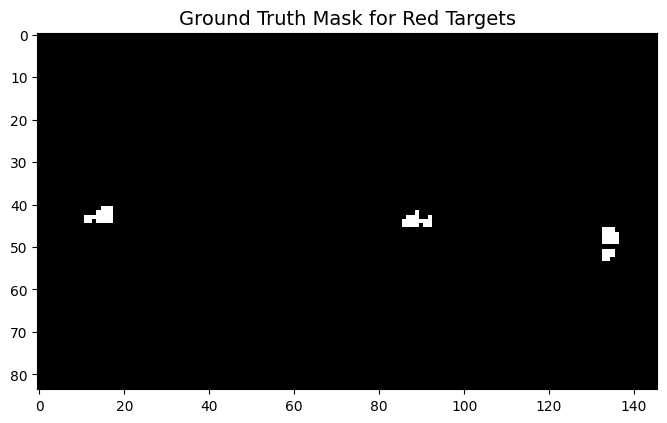

In [25]:
# Visualize ground truth mask

class_map_numpy = class_map.load()
class_map_numpy = class_map_numpy.squeeze()  # Remove the singleton dimension
class_map_mask = (class_map_numpy == 1)  # True for target, False for background

# Display ground truth mask
plt.figure(figsize=(8, 6))
plt.imshow(class_map_mask, cmap='gray')
plt.title("Ground Truth Mask for Red Targets", fontsize=14)
plt.show()

By now, we have a clean hsi data named as hsi_data_cleaned and a target signature named as target_spectrum both having 254 bands. We also have a ground truth mask for comparison of performance of various target detection algorithms.

#Step 2: Coding the hyperspectral target detection algorithms (SAM, MF, ACE and CEM), analyzing their results, and compairing their performances using Receiver Operating Characteristics (ROC) curve.



## Target Detection Algorithms

We implement four classical statistical hyperspectral target detection algorithms: **SAM, MF, ACE, and CEM**.  
All algorithms (implemented in this tutorial) operate on a **mean-centered hyperspectral data cube** $$X \in \mathbb{R}^{N \times B}$$, where \(N\) is the number of pixels and \(B\) is the number of spectral bands.  
The **target signature** is denoted as $$\mathbf{t} \in \mathbb{R}^{B}$$.


### 1. Spectral Angle Mapper (SAM)

SAM measures the **spectral similarity** between a pixel $({x})$ and the target $({t})$ using the angle between their vectors:

$$
\text{SAM}(\mathbf{x}_i, \mathbf{t}) = \arccos \left( \frac{\mathbf{x}_i^T \mathbf{t}}{\|\mathbf{x}_i\| \, \|\mathbf{t}\|} \right)
$$

- Small angles indicate higher similarity.
- In our implementation, we use a negative sign so that **higher scores indicate stronger detection**:

$$
\text{score}_i = - \text{SAM}(\mathbf{x}_i, \mathbf{t})
$$

**Note:** For consistency with the other algorithms, **SAM is also implemented on mean-centered data**, i.e., both the data and target are centered by subtracting the mean background spectrum $\boldsymbol{\mu}$.


### 2. Matched Filter (MF)

MF enhances the **target spectral signature** while suppressing background:

$$
\mathbf{w}_{\text{MF}} = \mathbf{\Sigma}^{-1} (\mathbf{t} - \boldsymbol{\mu})
$$

$$
\text{MF}(\mathbf{x}_i) = (\mathbf{x}_i - \boldsymbol{\mu})^T \mathbf{w}_{\text{MF}}
$$

- $(\boldsymbol{\mu}) $ is the mean background spectrum.
- $(\mathbf{\Sigma}) $ is the covariance of the background.
- Output scores are **normalized** to [0,1] for visualization.



### 3. Adaptive Cosine Estimator (ACE)

ACE detects the target by **measuring the Mahalanobis distance along the target direction**:

$$
\text{ACE}(\mathbf{x}_i) = \frac{\left[ (\mathbf{t}-\boldsymbol{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x}_i - \boldsymbol{\mu}) \right]^2}{\left[ (\mathbf{t}-\boldsymbol{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{t}-\boldsymbol{\mu}) \right] \, \left[ (\mathbf{x}_i - \boldsymbol{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x}_i - \boldsymbol{\mu}) \right]}
$$

- Accounts for both **background covariance** and the **target direction**.
- Output scores are **normalized** to [0,1].



### 4. Constrained Energy Minimization (CEM)

CEM designs a **filter that passes the target signature while minimizing background energy**:

$$
\mathbf{w}_{\text{CEM}} = \frac{\mathbf{R}^{-1} (\mathbf{t} - \boldsymbol{\mu})}{(\mathbf{t} - \boldsymbol{\mu})^T \mathbf{R}^{-1} (\mathbf{t} - \boldsymbol{\mu})}
$$

$$
\text{CEM}(\mathbf{x}_i) = (\mathbf{x}_i - \boldsymbol{\mu})^T \mathbf{w}_{\text{CEM}}
$$

- $(\mathbf{R}) $ is the correlation (or covariance) matrix of the background.
- **Note:** In this tutorial, $(\mathbf{R}) $ represents the correaltion matrix.  
- Emphasizes the target while minimizing output variance for background pixels.  
- Scores are **normalized** to [0,1].



In [56]:
# Write functions for various target detection algorithms.

# Before this, another function is created to flatten the hsi cube.
# For consistency, we will mean center the data and target while applying the following algorithms.
# -----------------------------------------------------------
# Utility: reshape cube (H, W, B) <-> matrix (N, B)
# -----------------------------------------------------------
def flatten_hsi(hsi):
    H, W, B = hsi.shape
    return hsi.reshape(-1, B), H, W

# -----------------------------------------------------------
# 1. Spectral Angle Mapper (SAM)
# -----------------------------------------------------------
def sam(hsi, target):
    X, H, W = flatten_hsi(hsi)
    t = target.astype(float)

    mean = np.mean(X, axis=0)
    Xc = X - mean # mean centering the data

    X = Xc
    t = t - mean # mean centering the target

    dot_xt = np.sum(X * t, axis=1)
    norm_x = np.linalg.norm(X, axis=1)
    norm_t = np.linalg.norm(t)

    #cos_sim = dot_xt / (norm_x * norm_t + 1e-12)  #For numerical stabililty, only to prevent division by zero.
    cos_sim = dot_xt / (norm_x * norm_t)
    cos_sim = np.clip(cos_sim, -1, 1)

    sam_map = -np.arccos(cos_sim) #negative sign to imply higher scores means better detection

    return sam_map.reshape(H, W)

# -----------------------------------------------------------
# 2. Matched Filter (MF)
# -----------------------------------------------------------
def mf(hsi, target):
    X, H, W = flatten_hsi(hsi)
    t = target.astype(float)

    mean = np.mean(X, axis=0)
    Xc = X - mean # mean centering the data

    #cov = np.cov(Xc, rowvar=False) + 1e-6 * np.eye(X.shape[1]) #np.eye creates an identity matrix
    cov = np.cov(Xc, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    w = inv_cov @ (t - mean)
    mf_scores = Xc @ w

    # Min-max normalization
    #mf_scores = (mf_scores - mf_scores.min()) / (mf_scores.max() - mf_scores.min() + 1e-12)
    mf_scores = (mf_scores - mf_scores.min()) / (mf_scores.max() - mf_scores.min())

    return mf_scores.reshape(H, W)

# -----------------------------------------------------------
# 3. ACE — Adaptive Cosine Estimator
# -----------------------------------------------------------
def ace(hsi, target):
    X, H, W = flatten_hsi(hsi)
    t = target.astype(float)

    mean = np.mean(X, axis=0)
    Xc = X - mean
    tc = t - mean

    #cov = np.cov(Xc, rowvar=False) + 1e-6 * np.eye(X.shape[1])
    cov = np.cov(Xc, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    num = (tc @ inv_cov @ Xc.T)**2

    denom1 = (tc @ inv_cov @ tc)
    denom2 = np.sum((Xc @ inv_cov) * Xc, axis=1)

    ace_scores = num / (denom1 * denom2 + 1e-12)

    # # Min-max normalization
    # ace_scores = (ace_scores - ace_scores.min()) / (ace_scores.max() - ace_scores.min() + 1e-12)
    ace_scores = (ace_scores - ace_scores.min()) / (ace_scores.max() - ace_scores.min())

    return ace_scores.reshape(H, W)

# -----------------------------------------------------------
# 4. CEM — Constrained Energy Minimization
# -----------------------------------------------------------
def cem(hsi, target):
    X, H, W = flatten_hsi(hsi)
    t = target.astype(float)

    # Standardize background for correlation
    X_mean = np.mean(X, axis=0)
    #X_std = np.std(X, axis=0) + 1e-12
    X_std = np.std(X, axis=0)
    X_norm = (X - X_mean) / X_std

    # Only mean-center target, do not divide by std
    t_centered = t - X_mean

    # Correlation matrix of background (for standardized data, correlation = covariance)
    #R = np.cov(X_norm, rowvar=False) + 1e-12 * np.eye(X.shape[1])
    R = np.cov(X_norm, rowvar=False)
    R_inv = np.linalg.inv(R)

    # Compute CEM filter
    w = R_inv @ t_centered / (t_centered.T @ R_inv @ t_centered)

    # Compute scores
    cem_scores = X_norm @ w

    # # Min-max normalize
    #cem_scores = (cem_scores - cem_scores.min()) / (cem_scores.max() - cem_scores.min() + 1e-12)
    cem_scores = (cem_scores - cem_scores.min()) / (cem_scores.max() - cem_scores.min())

    return cem_scores.reshape(H, W)


In [57]:
# We now make two functions
# 1) to visualize detection score results from algorithms and histograms of the scores to visualize the scene
# 2) visualize a binary map of the scene in terms of target (1) and background (0)
def visualize_score_and_hist(score_map, title="Detection Score Map", cmap='gray', bins=200):
    """
    Displays a detection score map and its histogram side by side.

    Parameters:
    - score_map: 2D array of detection scores (H, W)
    - title: str, title for the detection map
    - cmap: str, colormap for the detection map
    - bins: int, number of bins in the histogram
    """

    scores = score_map.flatten()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Score Map ---
    im = axes[0].imshow(score_map, cmap=cmap)
    axes[0].set_title(title, fontsize=14)
    plt.colorbar(im, ax=axes[0])

    # --- Histogram ---
    axes[1].hist(scores, bins=bins, color='gray', edgecolor='black')
    axes[1].set_title(f"Histogram of Scores", fontsize=14)
    axes[1].set_xlabel("Score Value")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Function to visualize detection score and visualize targets as 1 and background as 0 (binary map) based on the
# threshold range of scores.
def visualize_detection_binary(score_map, lower_threshold=None, upper_threshold=None,
                               title="Detection Result", cmap='gray', bins=200):
    """
    Visualizes detection score map as binary (white=target, black=background)
    and its histogram side by side with optional threshold range.

    Parameters:
    - score_map: 2D array (H, W) of detection scores
    - lower_threshold: float, optional lower bound
    - upper_threshold: float, optional upper bound
    - title: str, title for the detection map
    - cmap: str, colormap
    - bins: int, number of histogram bins
    """
    # Binarize based on thresholds
    visual_map = np.zeros_like(score_map)
    if lower_threshold is not None and upper_threshold is not None:
        visual_map[(score_map >= lower_threshold) & (score_map <= upper_threshold)] = 1
    elif lower_threshold is not None:
        visual_map[score_map >= lower_threshold] = 1
    elif upper_threshold is not None:
        visual_map[score_map <= upper_threshold] = 1
    else:
        visual_map = score_map  # fallback to original if no thresholds provided

    # Flatten scores for histogram
    scores = score_map.flatten()

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Binary detection map
    im = axes[0].imshow(visual_map, cmap=cmap)
    axes[0].set_title(f"{title} (Binary Map)")
    plt.colorbar(im, ax=axes[0])

    # Histogram
    axes[1].hist(scores, bins=bins, color='gray', edgecolor='blue')
    if lower_threshold is not None:
        axes[1].axvline(lower_threshold, color='red', linestyle='--', label=f'Lower = {lower_threshold}')
    if upper_threshold is not None:
        axes[1].axvline(upper_threshold, color='green', linestyle='--', label=f'Upper = {upper_threshold}')
    if lower_threshold is not None or upper_threshold is not None:
        axes[1].legend()
    axes[1].set_title(f"Histogram of {title} Scores")
    axes[1].set_xlabel("Score Value")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [58]:
# Now, you can compute scores of particular algorithms and visualize their results.
# For eg., let's compute SAM scores and visulaize its results.

sam_scores = sam(hsi_data_cleaned, target_spectrum)

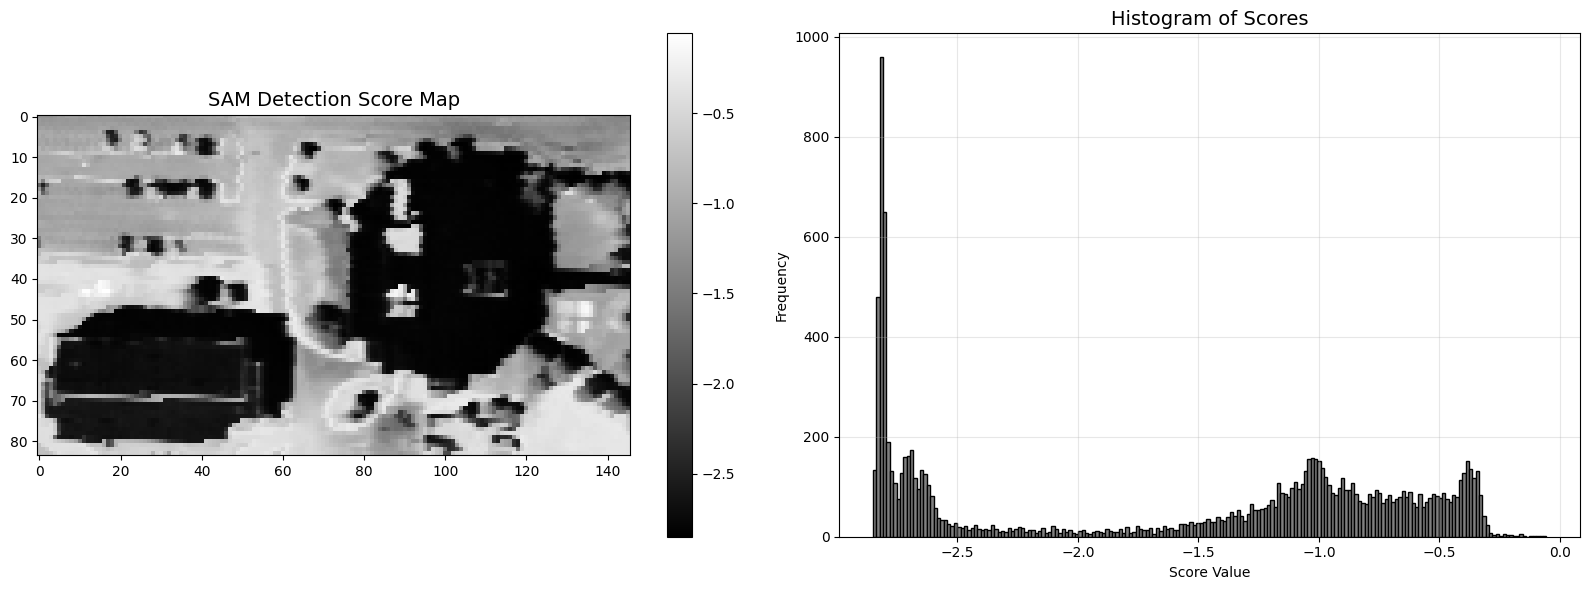

In [59]:
# Let's visulaize the SAM score map of the scene and its histogram
visualize_score_and_hist(sam_scores, title="SAM Detection Score Map")

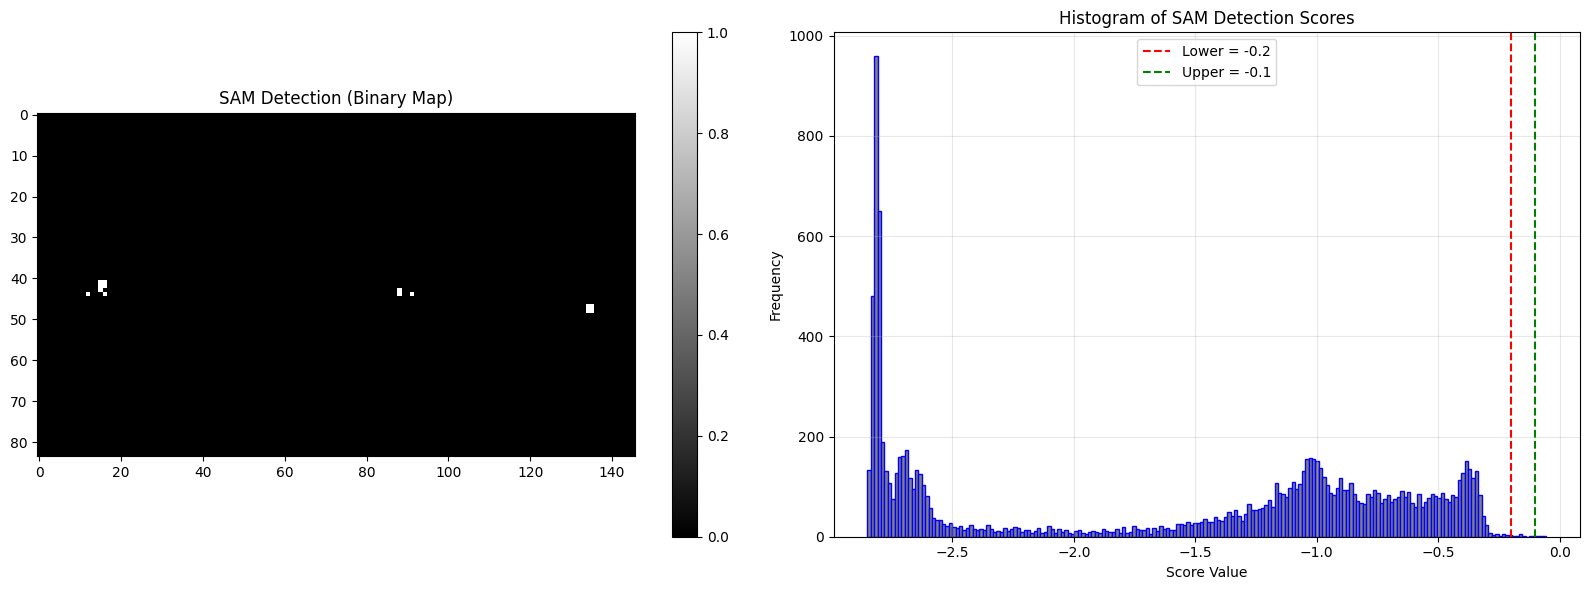

In [60]:
# Let's see how different threshold affect our binary map to locate targets
# I chose lower threshold = -0.2 and upper threshold = -0.1 for SAM.
# Play with various threshold values, and see how detection map changes.

visualize_detection_binary(sam_scores, lower_threshold=-0.2, upper_threshold=-0.1, title="SAM Detection")

Similarly, you can compute scores for other algorithms and visualize the results with various thresholds. Play with various thresholds in cells below to see how results change.


In [61]:
# Compute detection scores from other algorithms.
mf_scores = mf(hsi_data_cleaned, target_spectrum)
ace_scores = ace(hsi_data_cleaned, target_spectrum)
cem_scores = cem(hsi_data_cleaned, target_spectrum)

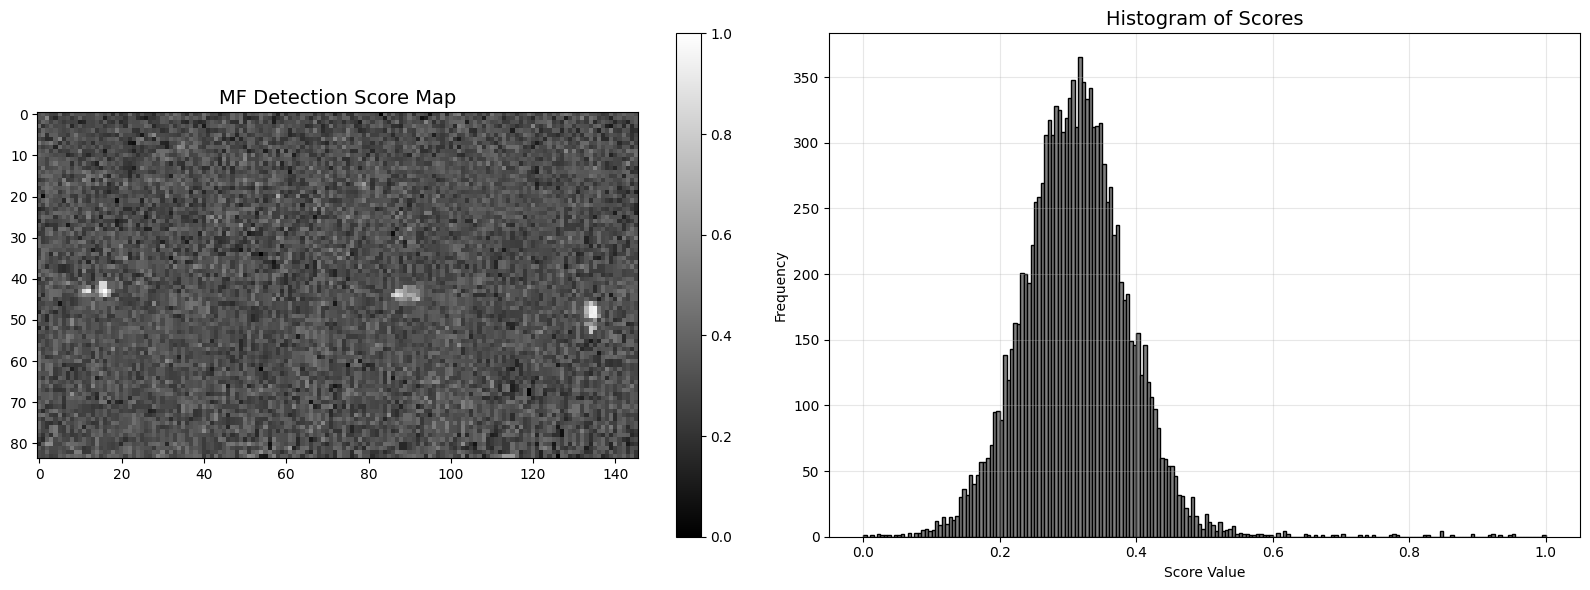

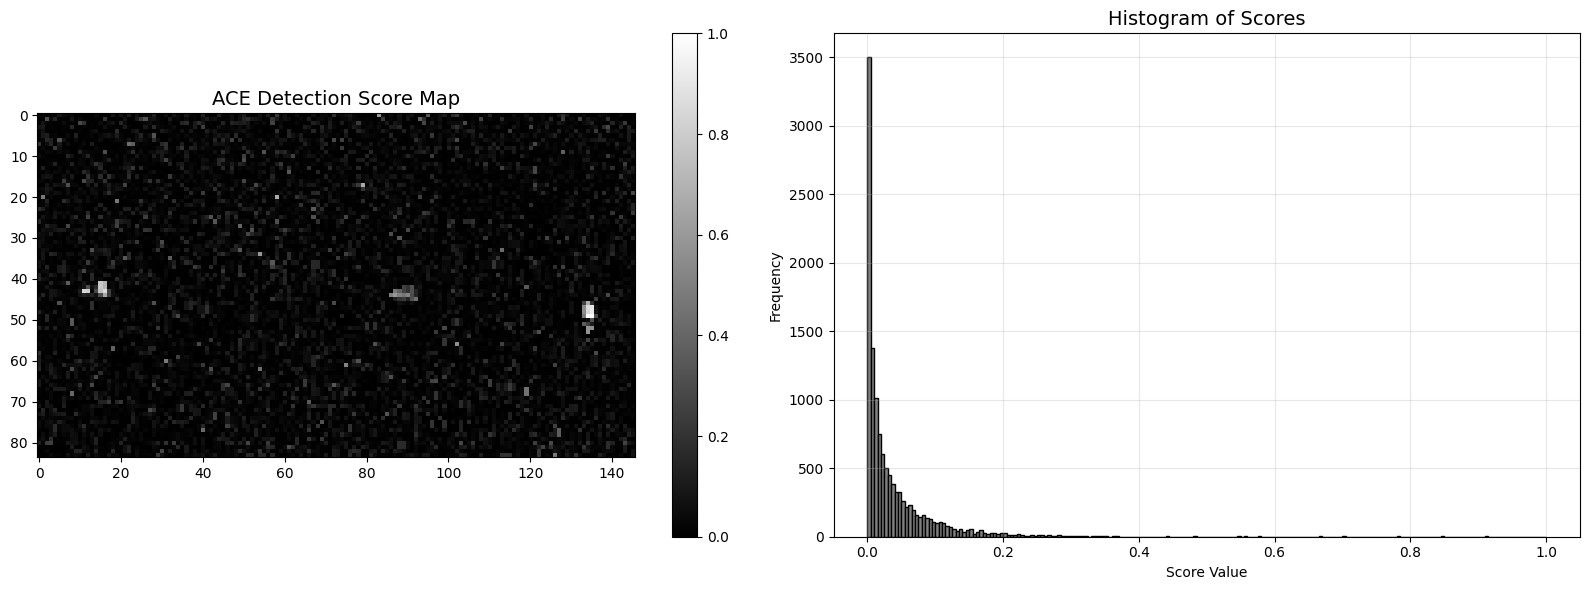

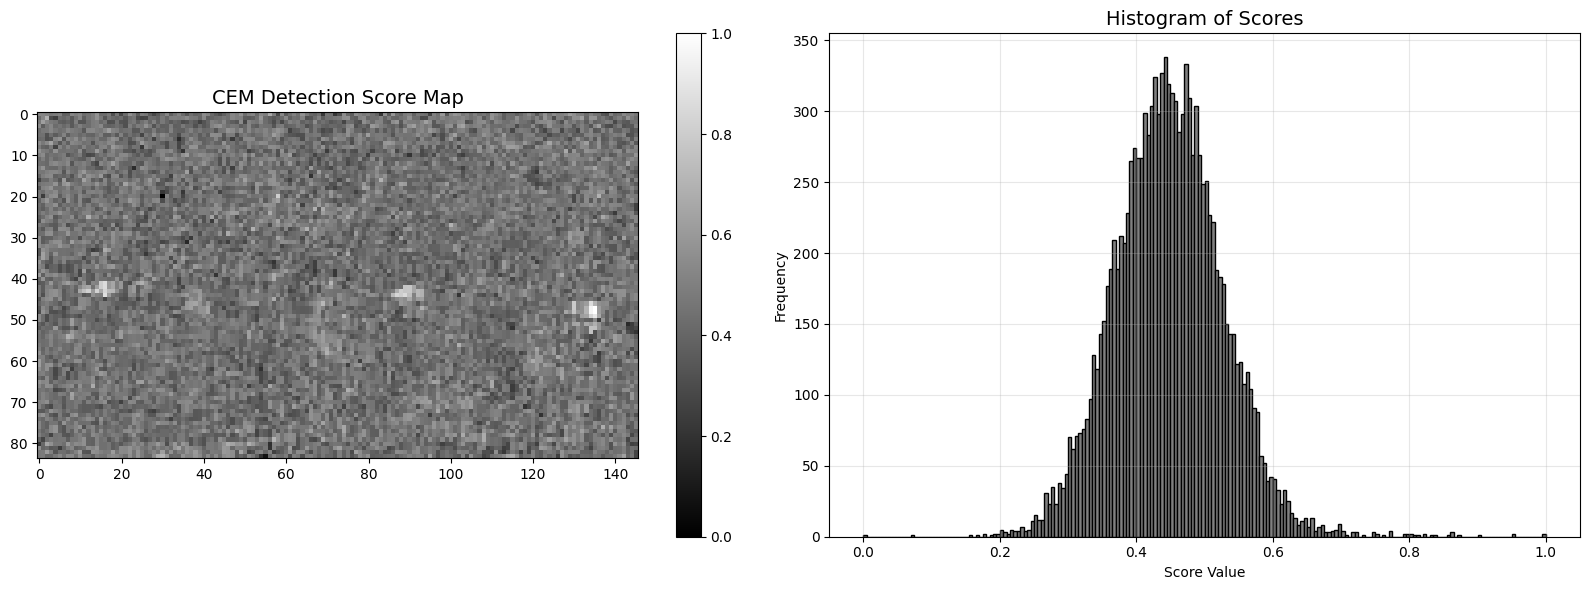

In [32]:
# Visualize detection scores from various algorithms.
visualize_score_and_hist(mf_scores, title="MF Detection Score Map")
visualize_score_and_hist(ace_scores, title="ACE Detection Score Map")
visualize_score_and_hist(cem_scores, title="CEM Detection Score Map")

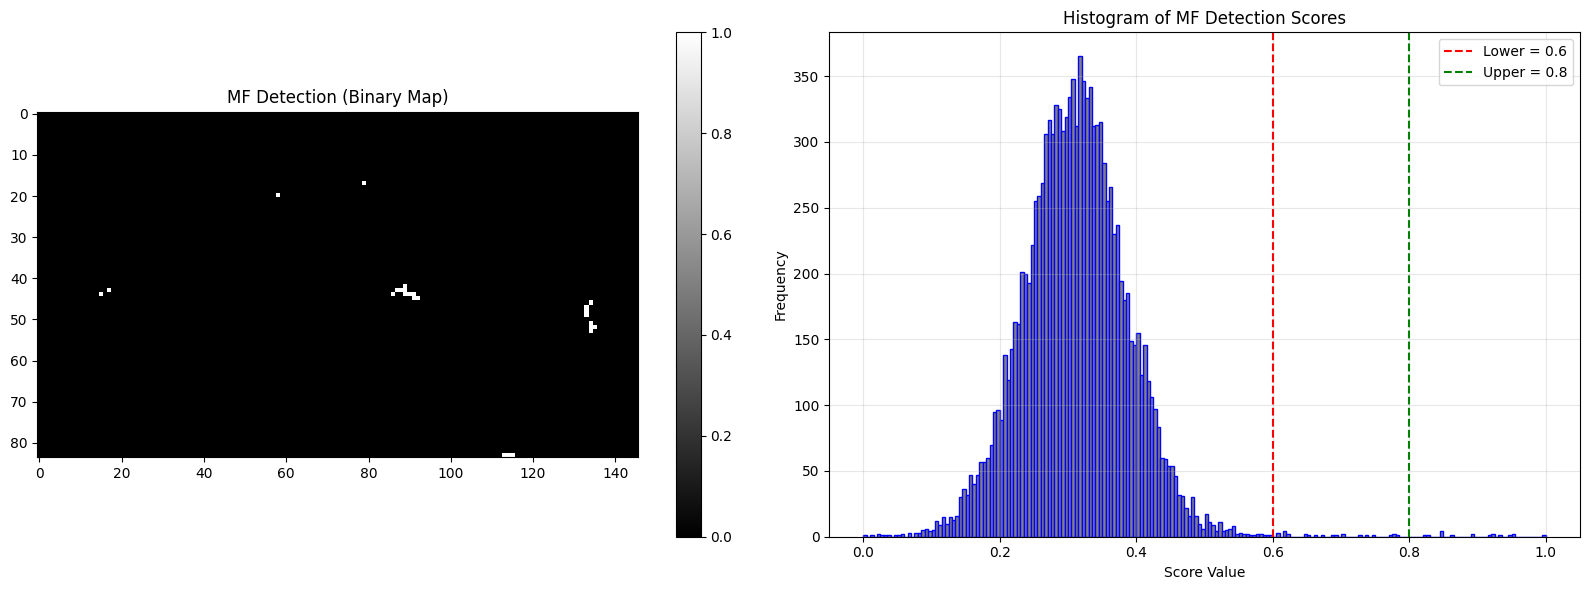

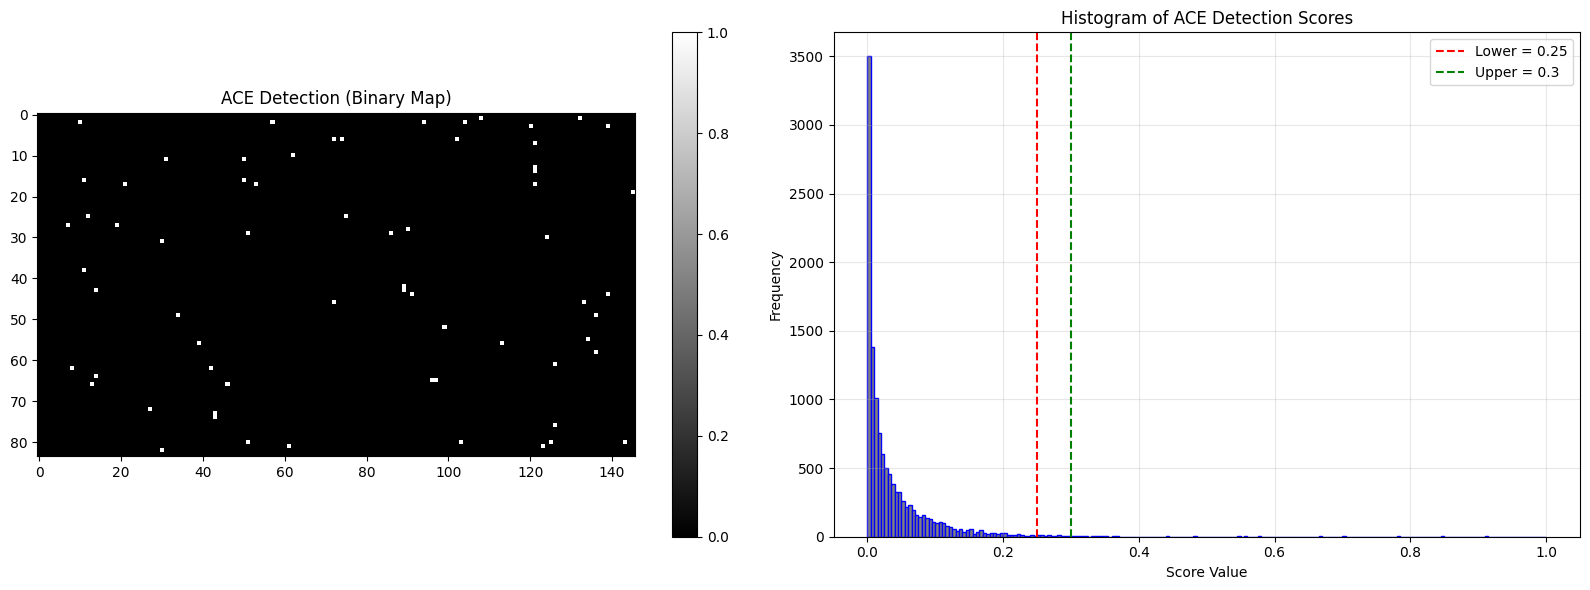

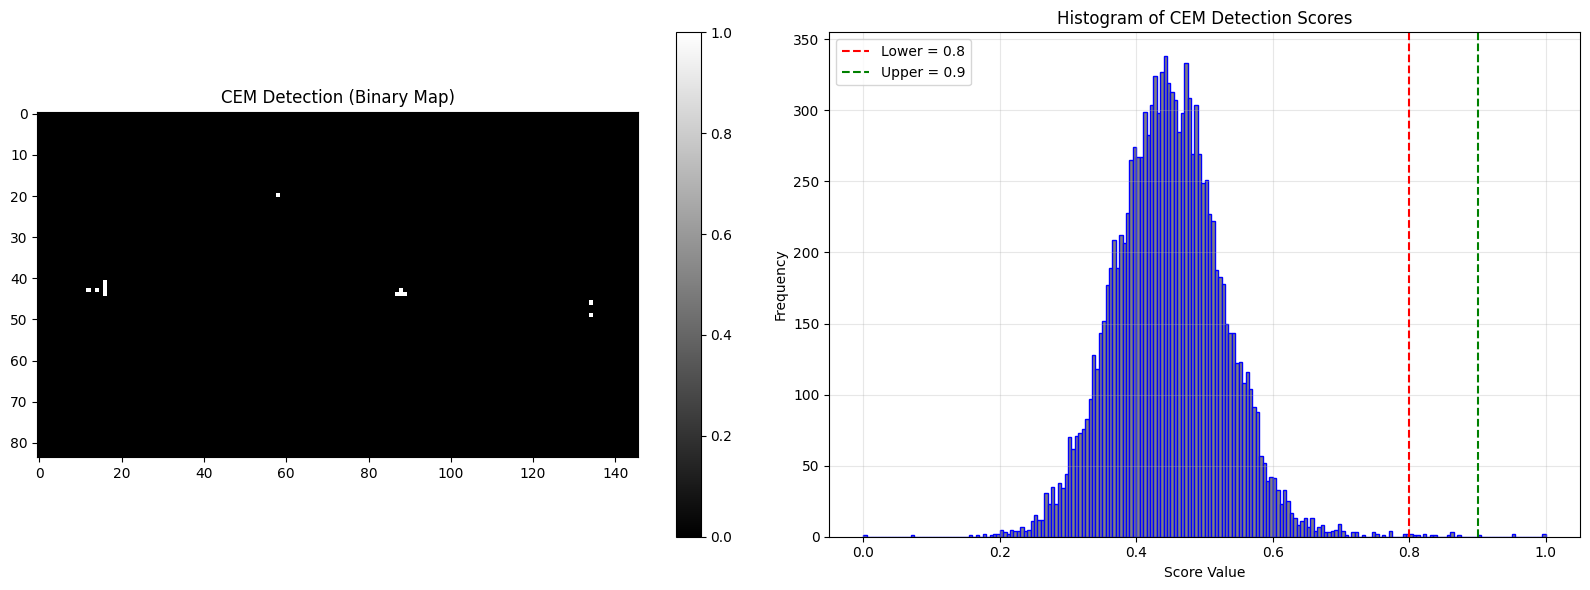

In [33]:
# Play with various thresholds
visualize_detection_binary(mf_scores, lower_threshold=0.6, upper_threshold=0.8, title="MF Detection")
visualize_detection_binary(ace_scores, lower_threshold=0.25, upper_threshold=0.3, title="ACE Detection")
visualize_detection_binary(cem_scores, lower_threshold=0.8, upper_threshold=0.9, title="CEM Detection")

After we computed detection scores from all algorithms, to compare their performances, we need to write another function to compute ROC curve, so, let's do that.

In [62]:
# Now, let's define other functions to compute ROC curve, Area under curve (AUC score) in both linear and log scale.

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def visualize_roc_linear_vs_log(detector_maps, detector_names, class_map_mask):
    """
    Plots ROC curves for multiple detectors side by side:
    - Left: linear scale
    - Right: log scale (FPR axis) with automatic lower bound
    """
    y_true = class_map_mask.flatten().astype(int)
    N_neg = np.sum(y_true == 0)

    plt.figure(figsize=(16, 6))

    # -------- LEFT PLOT: Linear Scale --------
    ax1 = plt.subplot(1, 2, 1)
    for scores, name in zip(detector_maps, detector_names):
        y_score = scores.flatten()
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

    ax1.plot([0, 1], [0, 1], 'k--', label="Random")
    ax1.set_title("ROC Curves (Linear Scale)", fontsize=14)
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="lower right")

    # Top axis for pixel counts
    ax1_top = ax1.twiny()
    ax1_top.set_xlim(ax1.get_xlim())
    fpr_ticks = np.linspace(0, 1, 6)
    fp_counts = (fpr_ticks * N_neg).astype(int)
    ax1_top.set_xticks(fpr_ticks)
    ax1_top.set_xticklabels(fp_counts)
    ax1_top.set_xlabel("False Positives (pixel count)", fontsize=12)

    # -------- RIGHT PLOT: Log Scale --------
    ax2 = plt.subplot(1, 2, 2)
    min_nonzero_fpr = np.inf

    # Find the smallest nonzero FPR across all detectors
    for scores in detector_maps:
        y_score = scores.flatten()
        fpr, tpr, _ = roc_curve(y_true, y_score)
        nonzero_fpr = fpr[fpr > 0]
        if len(nonzero_fpr) > 0:
            min_nonzero_fpr = min(min_nonzero_fpr, np.min(nonzero_fpr))

    # If no nonzero FPR found, default to 1e-6
    if min_nonzero_fpr == np.inf:
        min_nonzero_fpr = 1e-6

    # Plot each detector
    for scores, name in zip(detector_maps, detector_names):
        y_score = scores.flatten()
        fpr, tpr, _ = roc_curve(y_true, y_score)

        # Replace zeros with minimum nonzero FPR
        fpr_plot = np.where(fpr == 0, min_nonzero_fpr, fpr)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr_plot, tpr, label=f"{name} (AUC={roc_auc:.3f})")

    ax2.plot([min_nonzero_fpr, 1], [0, 1], 'k--', label="Random")
    ax2.set_xscale("log")
    ax2.set_title("ROC Curves (Log Scale)", fontsize=14)
    ax2.set_xlabel("False Positive Rate (log scale)")
    ax2.set_ylabel("True Positive Rate")
    ax2.grid(True, alpha=0.3, which="both")
    ax2.legend(loc="lower right")

    # Top axis for pixel counts
    ax2_top = ax2.twiny()
    ax2_top.set_xscale("log")
    ax2_top.set_xlim(ax2.get_xlim())
    fpr_ticks_log = np.logspace(np.log10(min_nonzero_fpr), 0, 6)
    fp_counts_log = (fpr_ticks_log * N_neg).astype(int)
    ax2_top.set_xticks(fpr_ticks_log)
    ax2_top.set_xticklabels(fp_counts_log)
    ax2_top.set_xlabel("False Positives (pixel count)", fontsize=12)

    plt.tight_layout()
    plt.show()


In [63]:
# Let's plot ROC curves for all the algorithms above.
detector_maps = [sam_scores, mf_scores, ace_scores, cem_scores]
detector_names = ["SAM", "MF", "ACE", "CEM"]

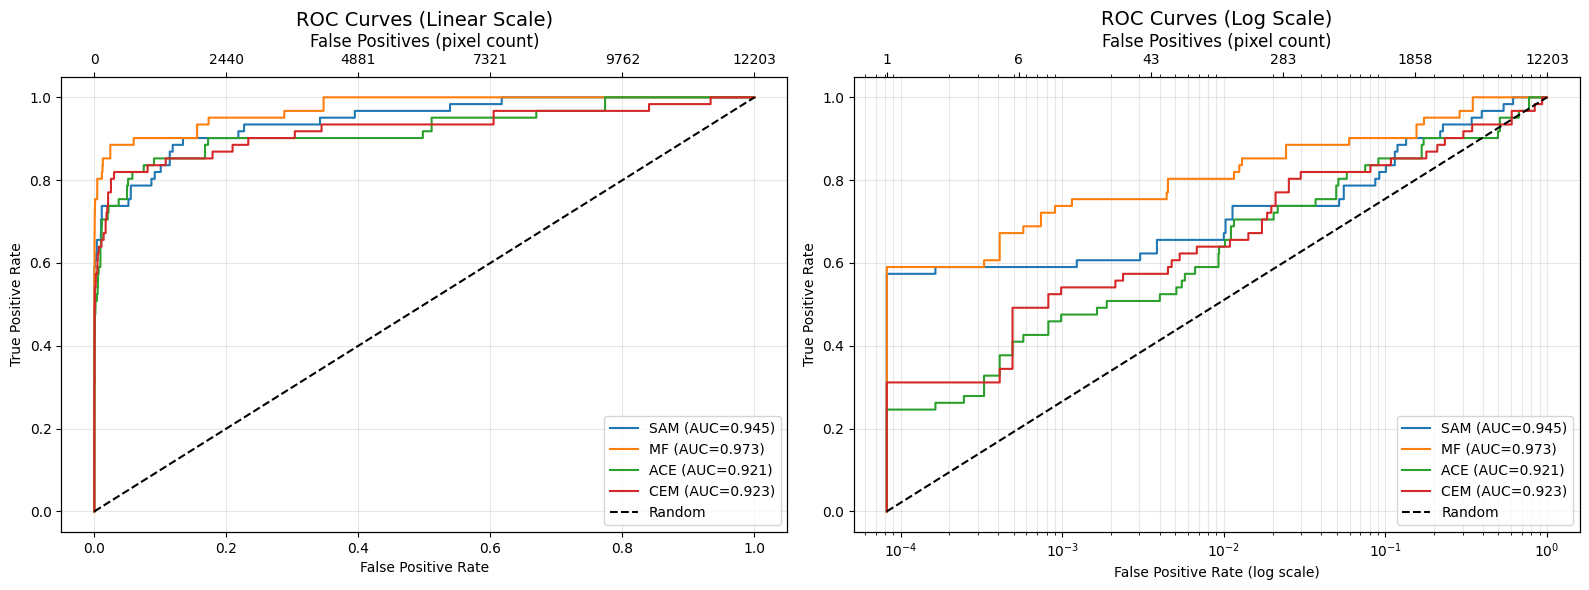

In [65]:
#Visualize the ROC curve, compute Area under curve (AUC) score to compare performances of various algorithms.
visualize_roc_linear_vs_log(detector_maps, detector_names, class_map_mask)

# Step 3: Now, let's reduce the hsi data into reduced space using PCA and apply target detection algorithms in reduced space. Also check if reconstructed data using all PC bands yields similar results as original hsi data.



In [85]:
# Reducing the data into PC space

# Flatten the data
X_flattened, H, W = flatten_hsi(hsi_data_cleaned)

# Compute band-wise mean
mu = X_flattened.mean(axis=0)

# SVD PCA
# Alternatively, you can also use EVD for PCA as well
U, S, Vt = np.linalg.svd(X_flattened - mu, full_matrices=False)  #SVD in mean cenetered data

V = Vt.T # eigen vectors
eigvals = S**2 / (X_flattened.shape[0] - 1)  # eigen values

Choose the value of number of PC components (top k eigen vectors) to project the original data into reduced space.

In [86]:
# Choose the value of 'k' to project data into k-dimensional PCA space
# To choose appropriate value of 'k', use help of explained variance ratio discussed in cell below.
k = 66

B = X_flattened.shape[1]  # number of bands
if k > B:
    print(f"Warning: k={k} > number of bands B={B}, using k=B instead")
    k = B

V_k = V[:,:k] #top-k eigen vectors # No need of sorting, because SVD sorts eigvals in descending order by default
eigvals_k = eigvals[:k] #top-k eigen values

# Project data and target_spectrum to k-dimensional PCA space
X_pca = (X_flattened - mu) @ V_k
target_pca = (target_spectrum - mu) @ V_k

# Reconstruct data from PCA space
X_reconstructed = X_pca @ V_k.T + mu
hsi_data_reconstructed = X_reconstructed.reshape(H, W, B)

# Reconstruct target from PCA space
target_reconstructed = target_pca @ V_k.T + mu

# Find the inverse covariance (needed later to pass into various functions)
cov_inv_pca = np.diag(1.0 / eigvals_k)

Number of eigenvectors to explain 99.99% variance: 66


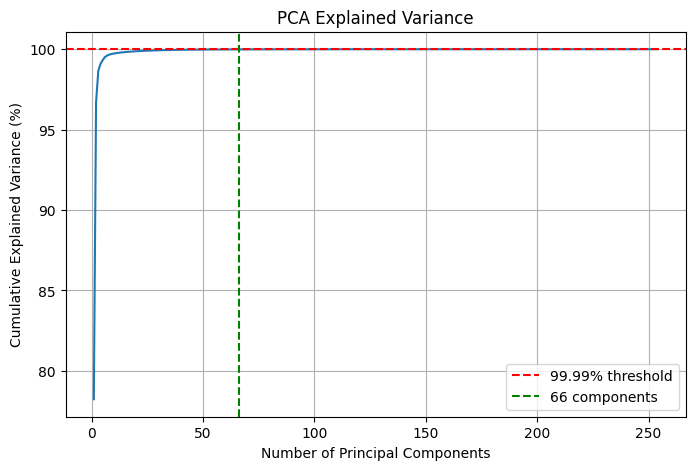

In [87]:
# Plot cumulative explained variance ratio.

# eigenvalues sorted in descending order
eigvals_sorted = np.sort(eigvals)[::-1]

# Compute explained variance for each principal component
explained_variance = eigvals_sorted / np.sum(eigvals_sorted)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Find the number of components needed for 99.99% explained variance
threshold = 0.9999
num_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of eigenvectors to explain {threshold*100:.2f}% variance: {num_components}")

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance*100)
plt.axhline(y=threshold*100, color='r', linestyle='--', label=f'{threshold*100:.2f}% threshold')
plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
# Confirm if the projected data has the desired number of bands as 'k' or not
hsi_data_reconstructed.shape
X_pca.shape

(12264, 66)

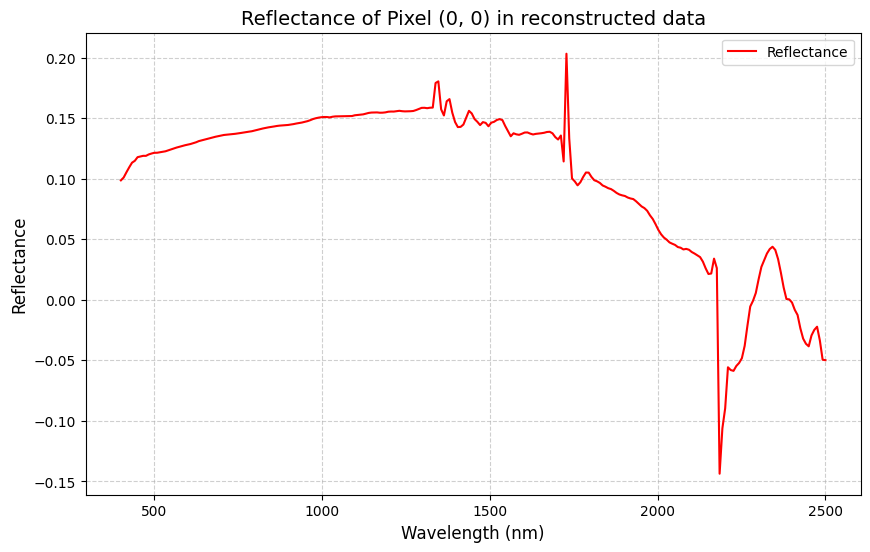

In [89]:
# Confirm and visualize the spectrum of the same random pixel (chosen before in the original data cube) in reconstructed data
# to ensure if reconstruction using desired bands

pixel_spectrum_reconstructed = hsi_data_reconstructed[0,0,:].flatten()

# Create a wavelength array corresponding to the spectral bands
wavelengths = np.linspace(400, 2500, 254)  # Adjust according to your data's spectral range

# Plot the pixel spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, pixel_spectrum_reconstructed, color='red', label='Reflectance')

plt.title('Reflectance of Pixel (0, 0) in reconstructed data', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

After the verification, we can now use the projected data and target in reduced space, and run target detection algorithms.

Note: You could compute these algorithms using earlier functions as well but since we had mean centered the data and computed covariances already inside those functions, we will write seperate functions for those algorithms especially for PCA reduced data, where we can pass covariance matrix.

In [91]:
# Algorithms for PCA version
# 1. SAM — PCA version
def sam_pca(X_pca, target_pca, H, W):
    t = target_pca.astype(float)
    dot_xt = np.sum(X_pca * t, axis=1)
    norm_x = np.linalg.norm(X_pca, axis=1)
    norm_t = np.linalg.norm(t)
    cos_sim = np.clip(dot_xt / (norm_x * norm_t), -1, 1)
    sam_map = -np.arccos(cos_sim)
    return sam_map.reshape(H, W)

# 2. MF — PCA version
def mf_pca(X_pca, target_pca, cov_inv_pca, H, W):
    t = target_pca.astype(float)
    w = cov_inv_pca @ t
    mf_scores = X_pca @ w
    mf_scores = (mf_scores - mf_scores.min()) / (mf_scores.max() - mf_scores.min())
    return mf_scores.reshape(H, W)

# 3. ACE — PCA version
def ace_pca(X_pca, target_pca, cov_inv_pca, H, W):
    t = target_pca.astype(float)
    num = (t @ cov_inv_pca @ X_pca.T)**2
    denom1 = t @ cov_inv_pca @ t
    denom2 = np.sum((X_pca @ cov_inv_pca) * X_pca, axis=1)
    ace_scores = num / (denom1 * denom2)
    ace_scores = (ace_scores - ace_scores.min()) / (ace_scores.max() - ace_scores.min())
    return ace_scores.reshape(H, W)

# # 4. CEM — PCA version
# Since for CEM, we used correlation earlier instead of covariance, so will do some additonal steps (PCA) inside this function
# to compute correlation. And we will pass original data into this function.
def cem_pca_full_corr(hsi, target, k):
    """
    PCA-based CEM preserving correlation (full covariance in PCA space)
    hsi: H x W x B hyperspectral cube
    target: B vector
    k: number of PCA components to keep
    """
    # Flatten cube
    X, H, W = flatten_hsi(hsi)
    t = target.astype(float)

    # Standardize original cube (correlation-based). Since, correlation = covariance in standardized data.
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_norm = (X - X_mean) / X_std
    t_centered = t - X_mean  # only mean-center target

    # PCA on standardized data
    U, S, Vt = np.linalg.svd(X_norm, full_matrices=False)
    V = Vt.T
    V_k = V[:, :k]

    # Project data and target
    X_pca = X_norm @ V_k
    t_pca = t_centered @ V_k

    # Compute full covariance in PCA space (off-diagonal preserved)
    cov_pca = np.cov(X_pca, rowvar=False)
    cov_inv_pca = np.linalg.inv(cov_pca)

    # Compute CEM filter
    w = cov_inv_pca @ t_pca / (t_pca.T @ cov_inv_pca @ t_pca)

    # Compute scores in PCA space
    cem_scores = X_pca @ w

    # Min-max normalize
    cem_scores = (cem_scores - cem_scores.min()) / (cem_scores.max() - cem_scores.min())

    return cem_scores.reshape(H, W)

In [92]:
# Compute detection scores of the algorithms in reduced space. .

# After PCA projection
X_pca_flat = X_pca  # shape (N, k)
H, W = hsi_data_cleaned.shape[:2]

# Compute detection scores of various algorithms in reduced space.
sam_map = sam_pca(X_pca_flat, target_pca, H, W)
mf_map  = mf_pca(X_pca_flat, target_pca, cov_inv_pca, H, W)
ace_map = ace_pca(X_pca_flat, target_pca, cov_inv_pca, H, W)
cem_map = cem_pca_full_corr(hsi_data_cleaned, target_spectrum, k)

In [93]:
detector_maps_pca = [sam_map, mf_map, ace_map, cem_map]
detector_names_pca = ["SAM", "MF", "ACE", "CEM"]

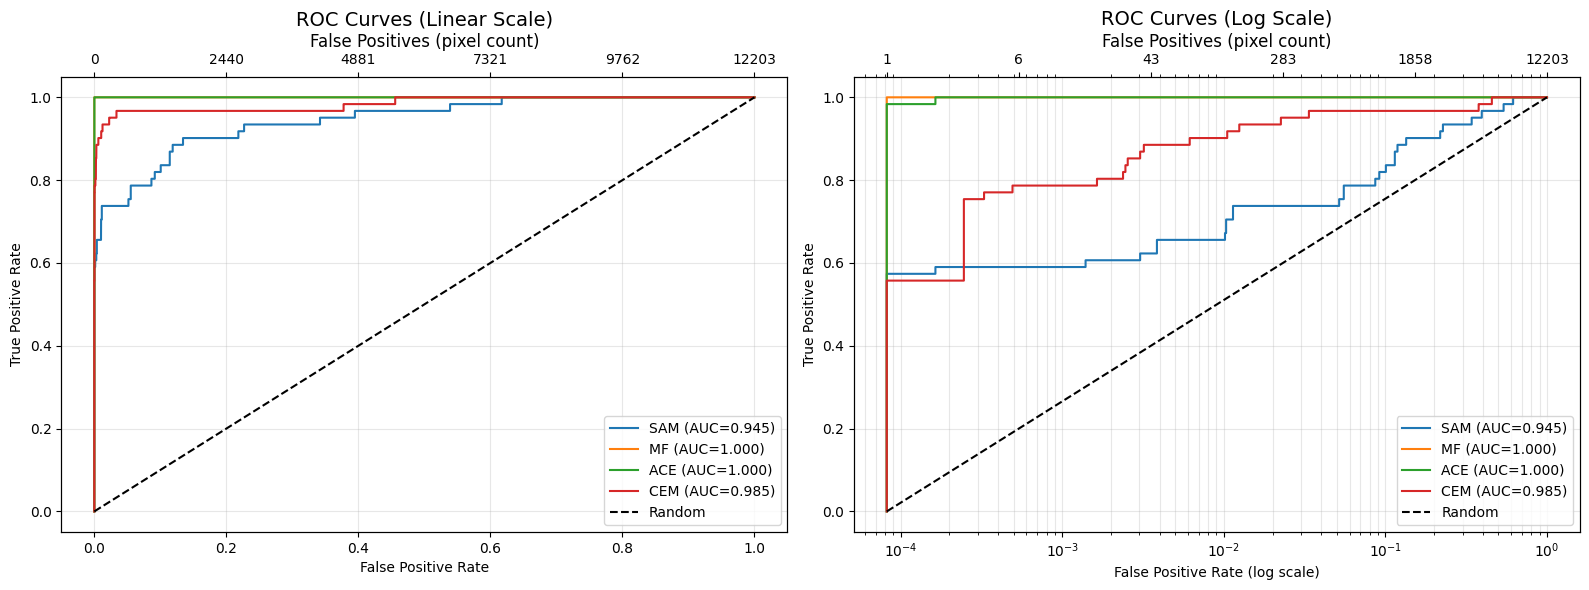

In [94]:
visualize_roc_linear_vs_log(detector_maps_pca, detector_names_pca, class_map_mask)

# Conclusion: Depending on the dataset and noise, the performances of these algorithms might increase or decrease in reduced space.